In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import seaborn as sns
import pymatreader
from meegkit import dss
 
from pycrostates.preprocessing import extract_gfp_peaks
from neurokit2.microstates.microstates_clean import microstates_clean
from mne_icalabel import label_components
from scipy.stats import kurtosis, skew
from data_quality.monte_carlo_search import MonteCarloSearch

In [2]:
from eeg_clean import epoch_stats, channel_stats_new, clean_new

In [3]:
def zapline_clean(raw, fline):
    data = raw.get_data().T # Convert mne data to numpy darray
    sfreq = raw.info['sfreq'] # Extract the sampling freq
   
    #Apply MEEGkit toolbox function
    out, _ = dss.dss_line(data, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    print(out.shape)

    cleaned_raw = mne.io.RawArray(out.T, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [330]:
data_folder = pathlib.Path(r"C:\Users\workbench\eirik_master\Data\mpi_lemon\sub-032528")
file = data_folder / "sub-010321.vhdr"

raw= mne.io.read_raw_brainvision(file, preload=False)
raw.drop_channels('VEOG')
raw.set_montage('standard_1020')

Extracting parameters from C:\Users\workbench\eirik_master\Data\mpi_lemon\sub-032528\sub-010321.vhdr...
Setting channel info structure...


Measurement date,"October 15, 2013 10:19:22 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,64 points
Good channels,61 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2500.00 Hz
Highpass,0.02 Hz
Lowpass,1000.00 Hz


In [348]:
print(raw.get_data().shape)

(61, 2597650)


In [349]:
data_folder = pathlib.Path(r"C:\Users\workbench\eirik_master\Data\mpi_lemon\sub-032528")
file = data_folder / "sub-010321.vhdr"

raw= mne.io.read_raw_brainvision(file, preload=True)
raw.drop_channels('VEOG')
raw.set_montage('standard_1020')
#raw.drop_channels(['TP9', 'TP10'])

raw_highpass = raw.copy().filter(l_freq=1, h_freq=None, verbose=False)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=100, verbose=False)
line_noise = zapline_clean(raw_lowpass, 50)
raw_down_sampled = line_noise.copy().resample(sfreq=201, verbose=False)

Extracting parameters from C:\Users\workbench\eirik_master\Data\mpi_lemon\sub-032528\sub-010321.vhdr...
Setting channel info structure...
Reading 0 ... 2597649  =      0.000 ...  1039.060 secs...


[PCA] Explained variance of selected components : 72.57%
Power of components removed by DSS: 0.24
(2597650, 61)
Creating RawArray with float64 data, n_channels=61, n_times=2597650
    Range : 0 ... 2597649 =      0.000 ...  1039.060 secs
Ready.


In [331]:
vmrk = data_folder / "sub-010002.vmrk"

In [332]:
events, events_mapping = mne.events_from_annotations(raw, event_id='auto')

Used Annotations descriptions: ['Comment/no USB Connection to actiCAP', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S200', 'Stimulus/S210']


In [351]:
baseline = (0, 0)  # means from the first instant to t = 0
ones_epochs = mne.Epochs(raw, events, [210, 200], tmin=0, tmax=2, baseline=None, preload=True)

Not setting metadata
480 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 480 events and 5001 original time points ...
0 bad epochs dropped


In [352]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5 * n_channels]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [1.5, 3.5],
        "theta": [4, 7.5],
        "alpha": [8, 13],
        "beta": [13.5, 25],
    }

    spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0, method='welch')
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    #psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

ec = eeg_power_band(ones_epochs[210])
eo = eeg_power_band(ones_epochs[200])

Effective window size : 0.819 (s)
Effective window size : 0.819 (s)


In [353]:
delta = [np.mean(ec[:, 0:61]), np.mean(eo[:, 0:61])]
theta = [np.mean(ec[:, 61:122]), np.mean(eo[:, 61:122])]
alpha = [np.mean(ec[:, 122:183]), np.mean(eo[:, 122:183])]
beta = [np.mean(ec[:, 183:244]), np.mean(eo[:, 183:244])]

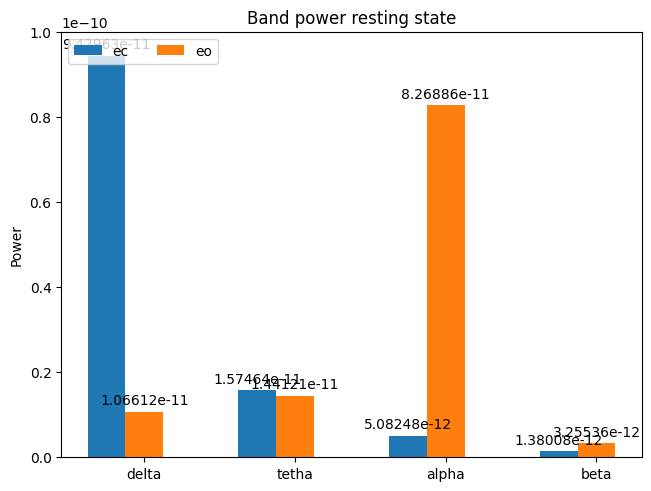

In [362]:
bands = ("delta", "tetha", "alpha", "beta")
power_means = {
    'ec': (delta[0], theta[0], alpha[0], beta[0]),
    'eo': (delta[1], theta[1], alpha[1], beta[1]),
}

x = np.arange(len(bands))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in power_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Power')
ax.set_title('Band power resting state')
ax.set_xticks(x + width, bands)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 0.0000000001)

plt.show()

In [350]:
for i in events:
    print(i)

[    0     0 99999]
[    0     0 10001]
[9251    0    1]
[47575     0     1]
[47598     0   210]
[52598     0   210]
[57598     0   210]
[62598     0   210]
[67598     0   210]
[72599     0   210]
[77599     0   210]
[82599     0   210]
[87599     0   210]
[92599     0   210]
[97599     0   210]
[102599      0    210]
[107599      0    210]
[112599      0    210]
[117600      0    210]
[122600      0    210]
[127600      0    210]
[132600      0    210]
[137600      0    210]
[142600      0    210]
[147600      0    210]
[152600      0    210]
[157601      0    210]
[162601      0    210]
[167601      0    210]
[172601      0    210]
[177601      0    210]
[182601      0    210]
[187601      0    210]
[192601      0    210]
[202739      0      1]
[202764      0    200]
[207764      0    200]
[212764      0    200]
[217764      0    200]
[222764      0    200]
[227764      0    200]
[232764      0    200]
[237765      0    200]
[242765      0    200]
[247765      0    200]
[252765      

In [343]:
ec = 210
eo = 200
start_times = []
end_times = []
previous = [np.inf, np.inf, np.inf]

for i in events:
    if i[2] == ec or i[2] == eo:
        if i[2] != previous[2]:
            start_times.append(i[0]/2500)

    else:
        if previous[2] == ec or previous[2] == eo:
            end_times.append(previous[0]/2500)
    
    previous = i
end_times.append(previous[0]/2500)

print(start_times)
print(end_times)

[19.0392, 81.1056, 142.9888, 204.778, 266.6964, 328.3656, 390.964, 452.8852, 532.156, 595.7992, 657.8096, 719.49, 781.1952, 842.3272, 911.2564, 972.9888]
[77.0404, 139.1068, 200.99, 262.7796, 324.698, 386.3672, 448.9652, 510.8864, 590.1572, 653.8004, 715.8108, 777.4912, 839.1964, 900.3288, 969.2576, 1030.99]


In [344]:
import random

In [346]:
random_ec = []
random_eo = []

for i in range(212):
    random_ec.append(random.randrange(0, 8, 2))
    random_eo.append(random.randrange(1, 9, 2))

print(random_ec)
print(random_eo)

[0, 4, 2, 6, 4, 6, 0, 4, 4, 0, 4, 6, 0, 6, 4, 6, 6, 2, 0, 4, 0, 2, 6, 0, 6, 0, 6, 2, 6, 6, 2, 6, 6, 0, 2, 0, 6, 4, 0, 2, 6, 6, 0, 6, 2, 6, 6, 2, 0, 0, 6, 0, 4, 6, 2, 2, 0, 2, 6, 4, 6, 0, 4, 2, 0, 6, 4, 6, 0, 6, 6, 4, 2, 4, 4, 6, 4, 2, 4, 2, 4, 6, 2, 2, 2, 4, 2, 4, 2, 0, 6, 2, 2, 4, 6, 2, 4, 2, 0, 0, 2, 6, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 4, 6, 0, 6, 4, 0, 4, 4, 6, 0, 2, 6, 0, 2, 6, 4, 6, 2, 4, 0, 4, 6, 4, 4, 2, 4, 2, 0, 4, 4, 2, 4, 4, 4, 4, 6, 0, 4, 6, 0, 2, 4, 6, 0, 0, 0, 0, 0, 6, 0, 0, 6, 4, 0, 4, 6, 6, 0, 2, 6, 4, 6, 0, 2, 4, 2, 2, 4, 2, 6, 4, 6, 2, 4, 0, 0, 6, 6, 2, 6, 2, 2, 6, 0, 2, 2, 4, 2, 6, 4, 2, 0, 2, 6, 0, 2, 2, 0, 2, 4]
[5, 3, 3, 3, 7, 7, 5, 3, 7, 1, 5, 5, 1, 1, 5, 3, 5, 7, 7, 3, 3, 5, 5, 3, 5, 3, 3, 1, 3, 1, 5, 7, 5, 1, 3, 3, 1, 7, 7, 3, 1, 7, 1, 5, 1, 5, 7, 1, 5, 3, 3, 7, 1, 3, 1, 1, 5, 3, 1, 5, 1, 3, 7, 5, 7, 5, 3, 7, 1, 7, 7, 5, 7, 5, 7, 1, 7, 1, 5, 1, 7, 7, 1, 1, 3, 3, 5, 5, 3, 7, 5, 1, 1, 5, 5, 7, 7, 1, 5, 5, 3, 7, 3, 5, 7, 5, 3, 3, 5, 1, 3, 5, 5, 1, 7, 7, 5, 3, 1, 1, 1,

In [62]:
events = mne.read_annotations(vmrk)

Finding 'sfreq' from header file: C:\Users\workbench\eirik_master\Data\mpi_lemon_test\sub-032301\sub-010002.vhdr


In [70]:
for i in range(events.to_data_frame().shape[0]):
    print(events.to_data_frame().loc[i])

onset          1970-01-01 00:00:00
duration                    0.0004
description           New Segment/
Name: 0, dtype: object
onset                           1970-01-01 00:00:00
duration                                     0.0004
description    Comment/no USB Connection to actiCAP
Name: 1, dtype: object
onset          1970-01-01 00:00:03.991600
duration                           0.0004
description                 Stimulus/S  1
Name: 2, dtype: object
onset          1970-01-01 00:00:06.375200
duration                           0.0004
description                 Stimulus/S  1
Name: 3, dtype: object
onset          1970-01-01 00:00:06.384800
duration                           0.0004
description                 Stimulus/S210
Name: 4, dtype: object
onset          1970-01-01 00:00:08.384800
duration                           0.0004
description                 Stimulus/S210
Name: 5, dtype: object
onset          1970-01-01 00:00:10.384800
duration                           0.0004
description  

In [17]:
print(raw_down_sampled.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 61 EEG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 highpass: 1.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2013-11-11 13:47:40 UTC
 nchan: 61
 projs: []
 sfreq: 201.0 Hz
>


Between GFP peaks

In [18]:
ones_epochs = mne.make_fixed_length_epochs(raw_down_sampled, 0.5, verbose=False, preload=True)

In [19]:
stats = epoch_stats.EpochStats(ones_epochs, switching_frq_thresholds=np.array([1, 1.4]))
stats.calc_stability()

In [20]:
epoched_stability = stats.quasi_stability.get_mean_abs_stab()
convex_stabilty = stats.quasi_stability.get_mean_stab()
epoched_switching_freq = stats.quasi_stability.switching_freqs[:, 0]
significant_switching_freq = stats.quasi_stability.switching_freqs[:, 1]
peaks = stats.n_gfp_peaks

Plots to investigate exclusion of epocs not following our assumptions.

Epoch averaged DISS

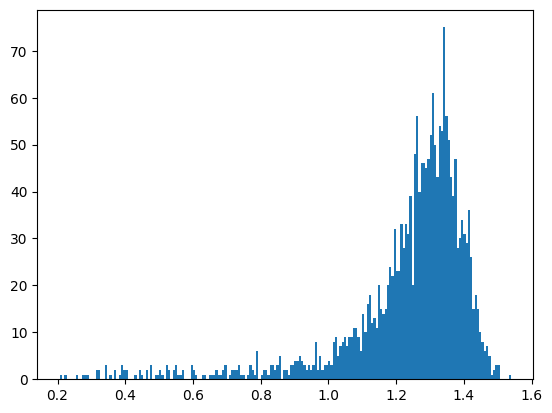

In [21]:
plt.hist(convex_stabilty, bins=200)
plt.show()

Stability transformed: absoluteDISS = |DISS-1| ... and averaged for each epoch. Now only high values indicate stability.

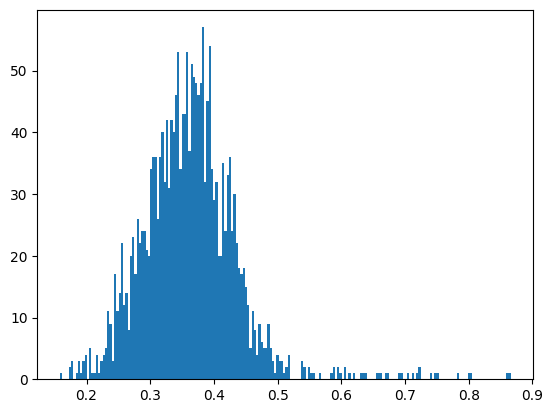

In [22]:
plt.hist(epoched_stability, bins=200)
plt.show()

Average epoch polarity inversion going from gfp peak to gfp peak, meaning DISS < 1.

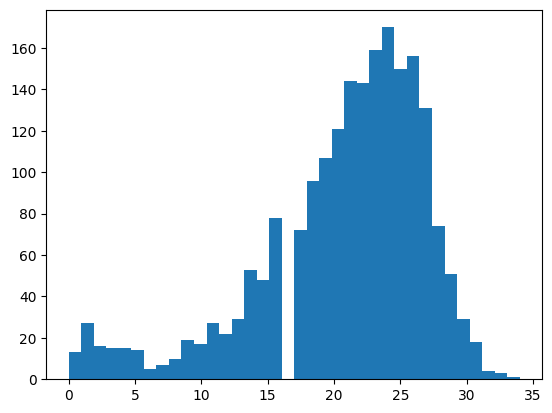

In [23]:
plt.hist(epoched_switching_freq, bins=36)
plt.show()

The same again, but only for shifts in polarity where higher stability is indicated (DISS > 1.4)

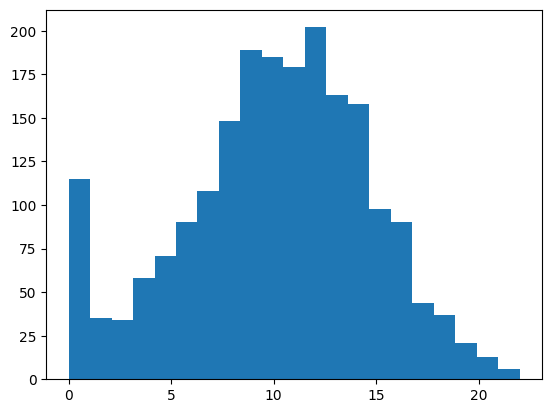

In [24]:
plt.hist(significant_switching_freq, bins=21)
plt.show()

Number of GFP peaks for each epoch

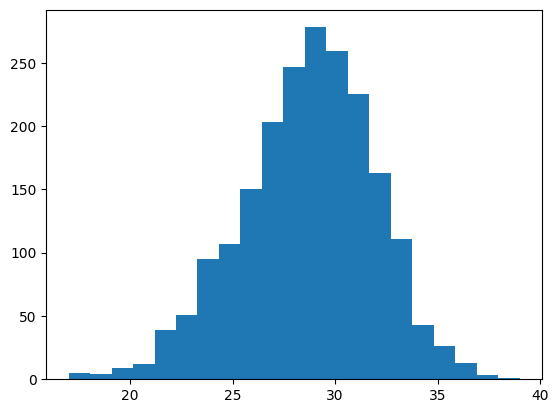

In [25]:
plt.hist(peaks, bins=21)
plt.show()

Looking at scatter plot between swithcing frequencies and number of GFP peaks

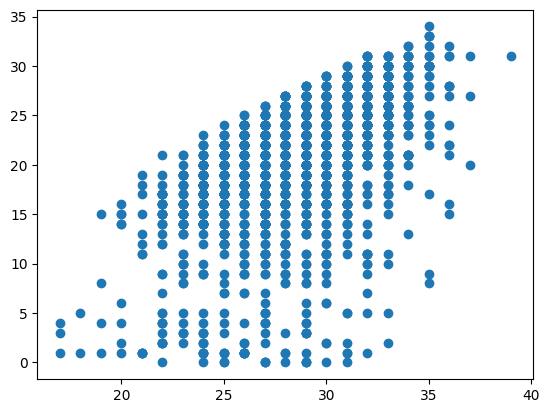

In [26]:
plt.scatter(peaks, epoched_switching_freq)
plt.show()

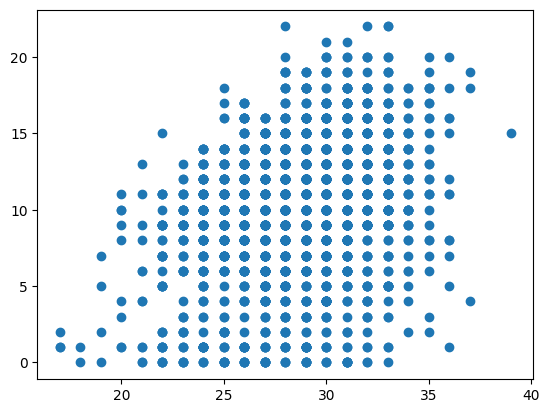

In [27]:
plt.scatter(peaks, significant_switching_freq)
plt.show()

Looking at average absoluteDISS in relation to switching frequencies.

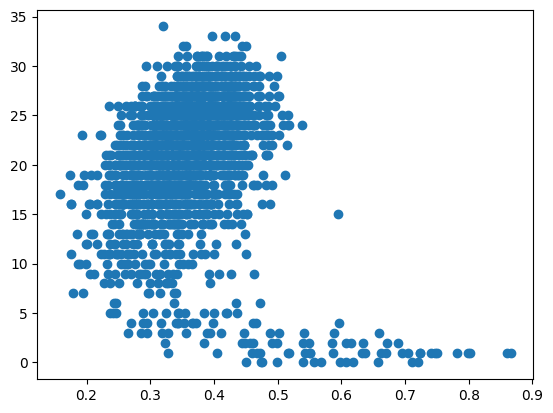

In [28]:
plt.scatter(epoched_stability, epoched_switching_freq)
plt.show()

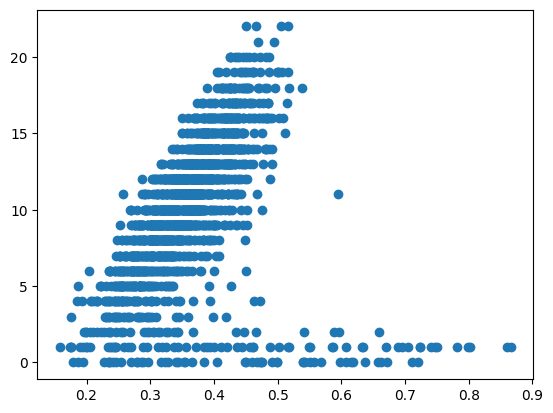

In [29]:
plt.scatter(epoched_stability, significant_switching_freq)
plt.show()

Same but with average DISS

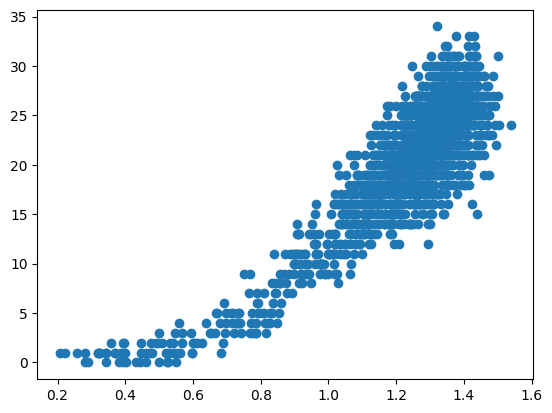

In [30]:
plt.scatter(convex_stabilty, epoched_switching_freq)
plt.show()

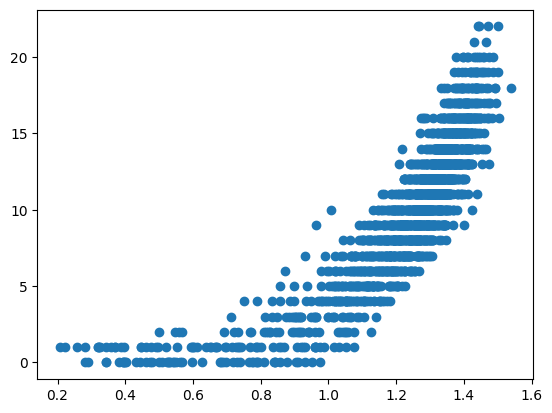

In [31]:
plt.scatter(convex_stabilty, significant_switching_freq)
plt.show()

Scatter of the two stability types

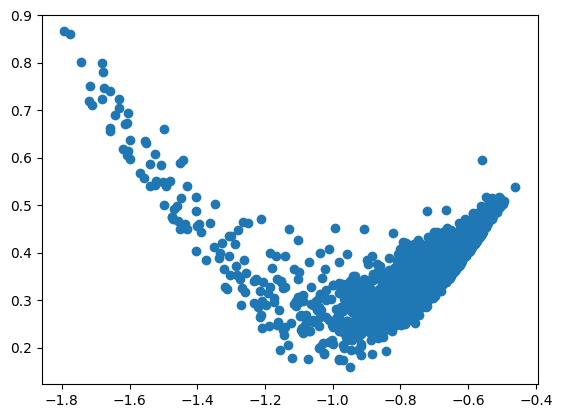

In [32]:
plt.scatter(convex_stabilty-2, epoched_stability)
plt.show()

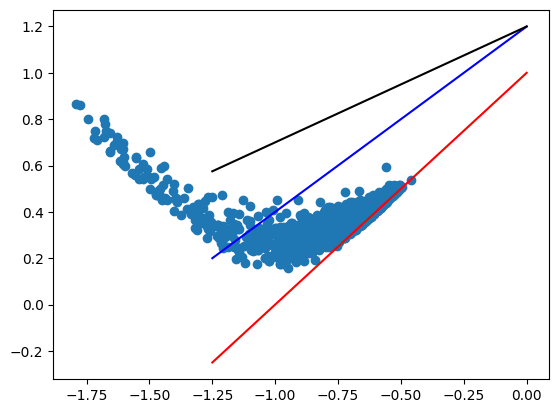

In [33]:
fit = np.poly1d([1, 1])
polyline = np.linspace(-1.25, 0, 100)
reg = np.poly1d([0.8, 1.2])
reg2 = np.poly1d([0.5, 1.2])
plt.scatter(convex_stabilty-2, epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.plot(polyline, reg(polyline), color="blue")
plt.plot(polyline, reg2(polyline), color="black")
plt.show()


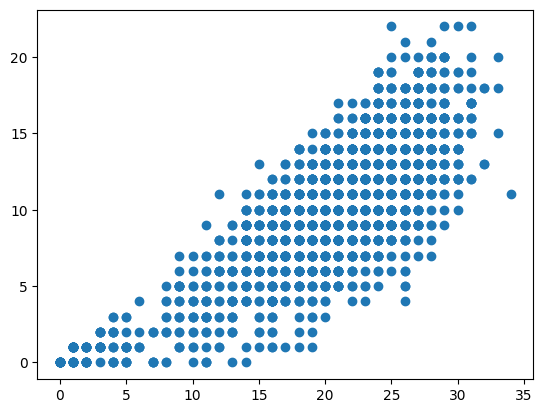

In [34]:
plt.scatter(epoched_switching_freq, significant_switching_freq)
plt.show()

At GFP peaks

In [35]:
at_epoched_stability = stats.peak_stability.get_mean_abs_stab()
at_convex_stabilty = stats.peak_stability.get_mean_stab()

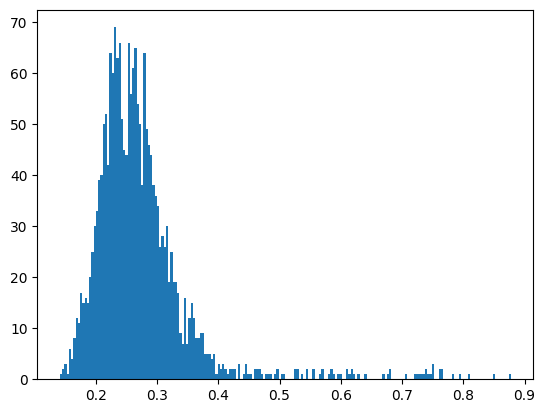

In [36]:
plt.hist(at_epoched_stability, bins=200)
plt.show()

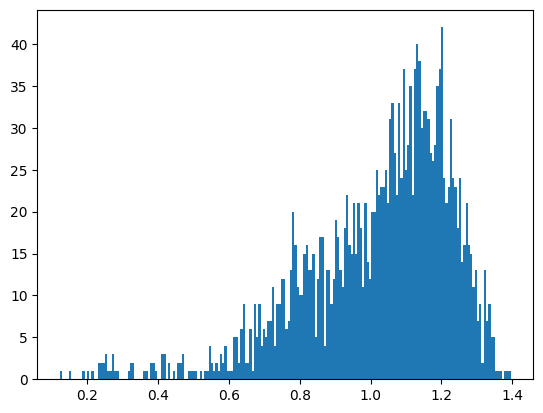

In [37]:
plt.hist(at_convex_stabilty, bins=200)
plt.show()

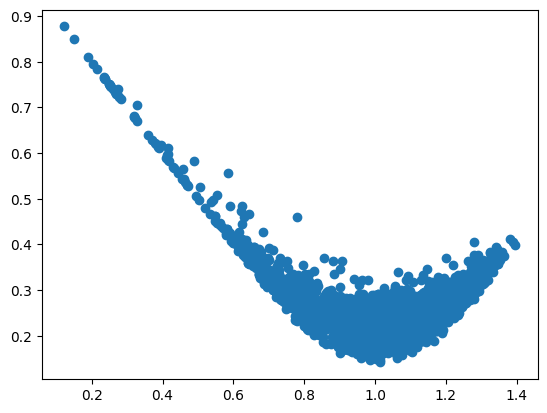

In [38]:
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.show()

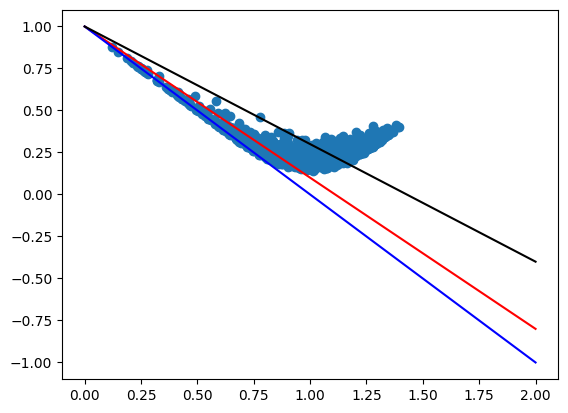

In [39]:
fit = np.poly1d([-0.9, 1])
reg = np.poly1d([-1, 1])
reg2 = np.poly1d([-0.7, 1])
polyline = np.linspace(0, 2, 100)
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.plot(polyline, reg(polyline), color="blue")
plt.plot(polyline, reg2(polyline), color="black")
plt.show()

In [40]:
print(fit)

 
-0.9 x + 1


In [41]:
def scale(values):
    v = values.reshape(-1, 1)
    scaler = sklearn.preprocessing.StandardScaler()
    noe = scaler.fit_transform(v)
    return noe

Bad channel evaluation

In [42]:
#ones_epochs.drop_channels('P4')
#ones_epochs.set_eeg_reference()

In [43]:
se_dicts = {
    "quasi": {"central": "mean", "spred_corrected": None},
    "peak": {"central": "mean", "spred_corrected": None},
    "n_peaks": {"central": "mean", "spred_corrected": None}
}


In [46]:
stats_channels = channel_stats_new.ChannelStatsNew(
    mne_epochs_object = ones_epochs,
    dist_specifics = se_dicts,
    sklearn_scaler=sklearn.preprocessing.MinMaxScaler()
)

Channel Satbility

At GFP peaks

In [47]:
at_test1 = stats_channels.peak_stab_change
test1 = stats_channels.quasi_stab_change
n_peaks = stats_channels.n_peaks_change

In [ ]:
#at_test1 = np.delete(at_test1, 51)
#at_test1 = np.delete(at_test1, 14)
#at_test1 = np.delete(at_test1, 5)
#at_test1 = np.delete(at_test1, 13)

In [48]:
print(at_test1.shape)

(61,)


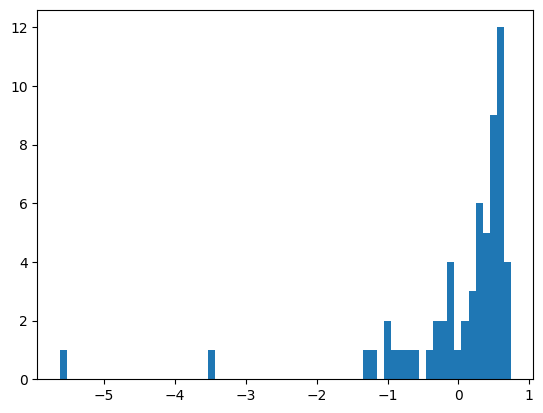

In [49]:
plt.hist(scale(at_test1), bins=64)
plt.show()

In [50]:
order = np.argsort(at_test1)
n = 58
print(skew(at_test1[order][:n]))
print(kurtosis(at_test1[order][:n]))
print(np.array(stats_channels.ch_name_list)[order])

-3.618541032395991
15.508756698414576
['FC5' 'T7' 'FT7' 'F5' 'TP7' 'F6' 'C5' 'F7' 'Fp1' 'FT8' 'F8' 'AF7' 'FC6'
 'T8' 'AF8' 'F3' 'AF3' 'FC3' 'PO10' 'TP8' 'C6' 'F4' 'C3' 'AF4' 'FC4' 'F1'
 'Fz' 'FC1' 'CP5' 'F2' 'C1' 'AFz' 'FC2' 'C2' 'CP1' 'Pz' 'Cz' 'CP2' 'CPz'
 'P6' 'P8' 'P2' 'Fp2' 'P1' 'C4' 'CP6' 'PO4' 'PO9' 'Oz' 'P5' 'P7' 'PO3'
 'P4' 'P3' 'CP3' 'POz' 'O2' 'O1' 'CP4' 'PO8' 'PO7']


In [ ]:
print(order[0])

21


Between GFP peaks

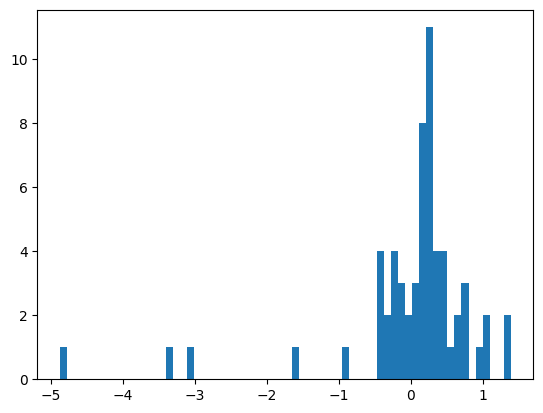

In [51]:
plt.hist(scale(scale(test1)), bins=64)
plt.show()

In [52]:
order = np.argsort(test1)
n = 63
print(skew(test1[order][:n]))
print(kurtosis(test1[order][:n]))
print(np.array(stats_channels.ch_name_list)[order])

-2.897542939050017
10.149242870641686
['T7' 'TP7' 'FC5' 'F6' 'CP5' 'P3' 'CP3' 'FT7' 'P1' 'PO7' 'CP4' 'P5' 'CP1'
 'P7' 'PO9' 'F5' 'PO3' 'C4' 'CP6' 'C5' 'F4' 'F3' 'F2' 'CP2' 'Fp1' 'C2'
 'F1' 'C3' 'C1' 'Fz' 'AF4' 'FC4' 'CPz' 'C6' 'FC6' 'Pz' 'P4' 'AF3' 'O1'
 'T8' 'Cz' 'P2' 'FT8' 'FC2' 'PO10' 'P6' 'FC1' 'AFz' 'AF7' 'P8' 'TP8' 'POz'
 'PO4' 'FC3' 'PO8' 'F7' 'AF8' 'Oz' 'O2' 'F8' 'Fp2']


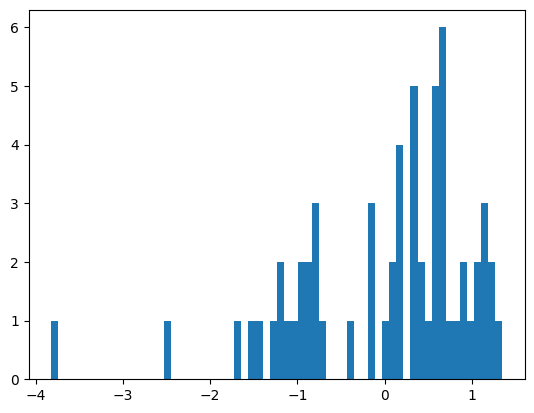

In [53]:
plt.hist(scale(scale(n_peaks)), bins=64)
plt.show()

In [54]:
order = np.argsort(n_peaks)
n = 63
print(skew(test1[order][:n]))
print(kurtosis(test1[order][:n]))
print(np.array(stats_channels.ch_name_list)[order])

-2.8975429390500183
10.149242870641698
['FC5' 'C5' 'FC3' 'FT7' 'F7' 'FC6' 'FT8' 'F5' 'T7' 'F8' 'C6' 'C3' 'T8'
 'AF7' 'TP8' 'F6' 'F3' 'Fp1' 'CP5' 'TP7' 'FC4' 'AF8' 'F4' 'PO10' 'C4' 'P6'
 'Oz' 'P8' 'AF3' 'O2' 'PO8' 'PO4' 'CP6' 'C2' 'C1' 'CP3' 'CPz' 'Fp2' 'FC1'
 'POz' 'CP2' 'P2' 'FC2' 'P4' 'Cz' 'Pz' 'CP4' 'F1' 'AF4' 'Fz' 'CP1' 'O1'
 'F2' 'AFz' 'PO9' 'PO3' 'P1' 'P5' 'P3' 'P7' 'PO7']


test threshold exclusions..

In [ ]:
clean_test = clean_new.CleanNew(ones_epochs, thresholds=[5, 3, 3], dist_specifics=se_dicts)

KeyboardInterrupt: 

In [ ]:
print(clean_test.bad_channel_index)

[ 7  9  9  6 12 16 11  2]


In [ ]:
print(ones_epochs.info["ch_names"][58])

PO4


Evaluate

In [ ]:
from data_quality import ica_score

In [ ]:
ones_epochs.set_eeg_reference()
evaluate = ica_score.IcaScore(ones_epochs)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]
[46]
[47]
[48]
[49]
[50]
[51]
[52]
[53]
[54]
[55]
[56]
[57]
[58]
[59]
[60]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]
[34]
[35]
[36]
[37]
[38]
[39]
[40]
[41]
[42]
[43]
[44]
[45]

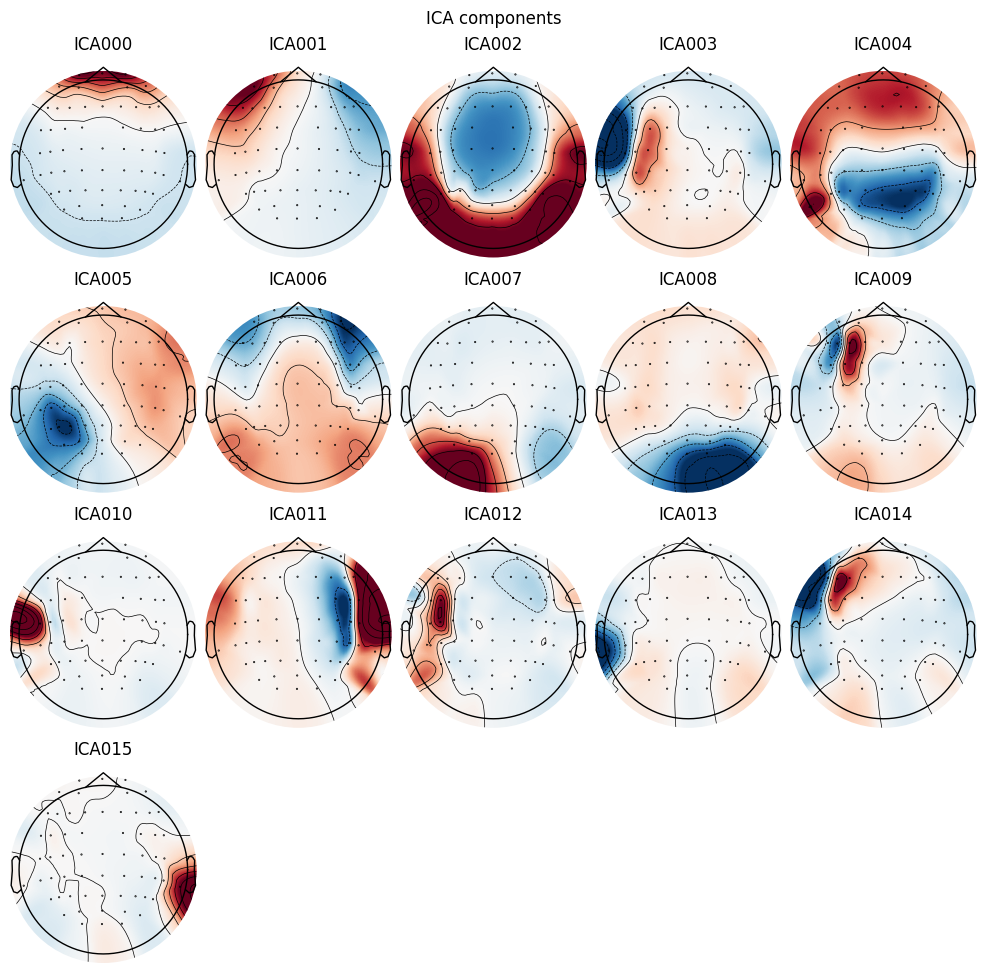

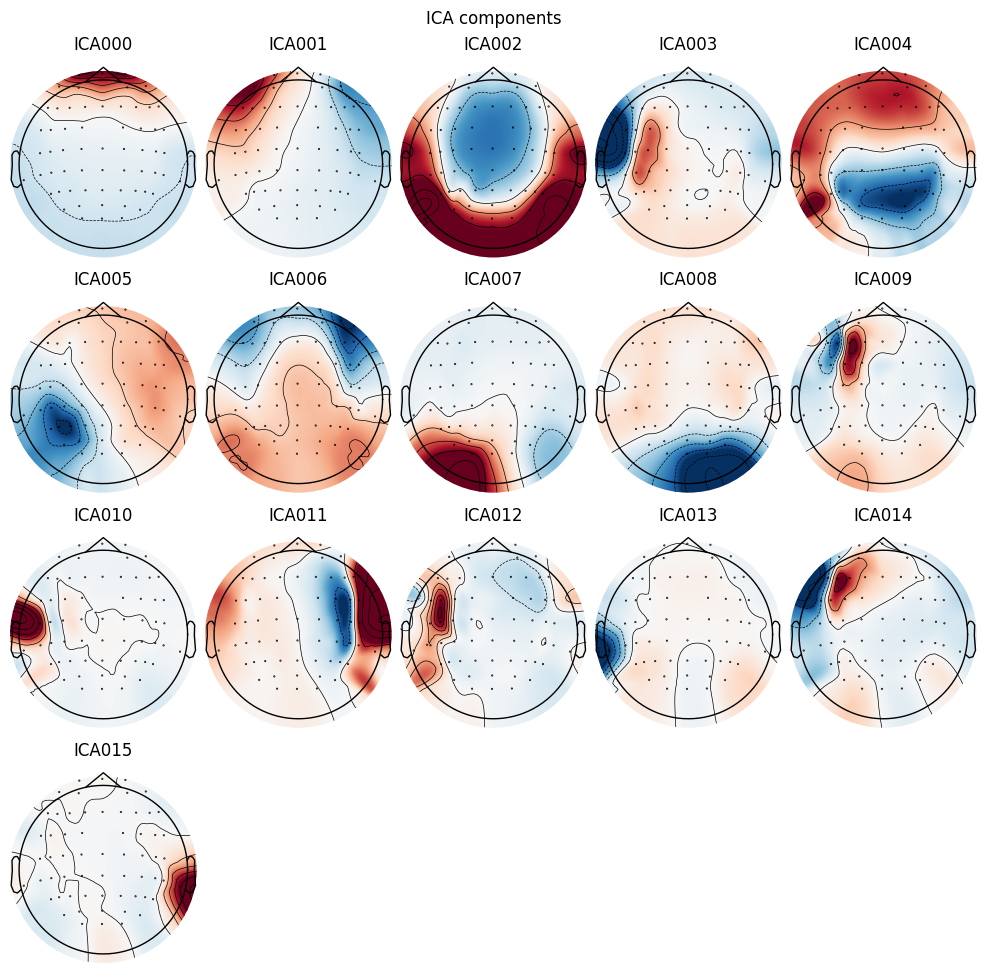

In [ ]:
evaluate.ica.plot_components()

In [ ]:
print(evaluate.ica_labels)

{'y_pred_proba': array([0.82064486, 0.9941089 , 0.8459572 , 0.8057215 , 0.9977401 ,
       0.99394846, 0.64473546, 0.6353693 , 0.724337  , 0.9319379 ,
       0.7837402 , 0.98122704, 0.8021997 , 0.85461426, 0.99641454,
       0.9100929 ], dtype=float32), 'labels': ['eye blink', 'eye blink', 'brain', 'muscle artifact', 'brain', 'brain', 'muscle artifact', 'heart beat', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'muscle artifact']}


In [ ]:
evaluate.get_n_components()

(2, 5)

In [ ]:
evaluate.get_explained_var(bio_components=True)

{'eeg': 0.36614295199140945}

In [ ]:
evaluate.get_explained_var()

{'eeg': 0.12872356096761162}